In [93]:
# import libraries
import numpy as np
import pandas as pd

from scipy import stats
from scipy.sparse import load_npz
import pickle

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

In [94]:
# import dataset
data = pd.read_pickle('drugsCom_data')

In [95]:
# import sparse matrix
from scipy.sparse import load_npz

term_matrix = load_npz('ngram_csr.npz')

# convert back to dataframe
term_matrix = pd.DataFrame(term_matrix.todense())

In [96]:
# import column headers for dataframe
import pickle

pickle_in = open('list.pickle', 'rb')
reviews_columns = pickle.load(pickle_in)

# add column headers back to dataframe
term_matrix.columns = reviews_columns

In [97]:
# add ratings back to the matrix to allow filtering
term_matrix['rating'] = data['rating']

In [98]:
term_matrix = term_matrix.dropna()

In [575]:
data.head(3)

,userID,drugName,condition,review,rating,date,usefulCount,character_count,word_count,clean_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,79,17,combination bystolic mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,741,141,son halfway fourth intuniv became concerned be...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,755,133,used another oral contraceptive pill cycle hap...


## Rating by Review Length

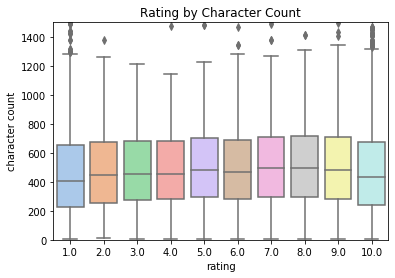

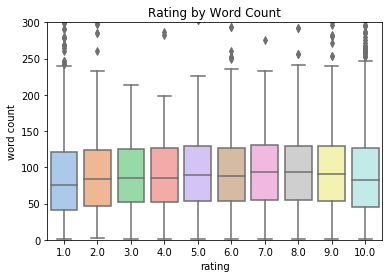

In [100]:
sns.set_palette('pastel')

# boxplot of character count vs. rating
_ = sns.boxplot(x='rating', y='character_count', data=data)
_ = plt.title('Rating by Character Count')
_ = plt.xlabel('rating')
_ = plt.ylabel('character count')
_ = plt.ylim(0,1500)
plt.show()

# boxplot of word count vs. rating
_ = sns.boxplot(x='rating', y='word_count', data=data)
_ = plt.title('Rating by Word Count')
_ = plt.xlabel('rating')
_ = plt.ylabel('word count')
_ = plt.ylim(0,300)
plt.show()

### Correlation

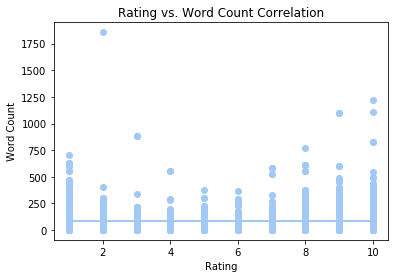

Correlation coefficient (r): 0.0267


In [578]:
# correlation of rating and word count
ratings = data.rating.values
word_counts = data.word_count.values

# calculate regression line and correlation coefficient
slope, intercept, r, p, stderr = stats.linregress(ratings, word_counts)

# plot regression line
plt.scatter(ratings, word_counts)
plt.plot(ratings, intercept + slope * ratings)
plt.xlabel('Rating')
plt.ylabel('Word Count')
plt.title('Rating vs. Word Count Correlation')
plt.show()

# print r
print('Correlation coefficient (r):', round(r,4))

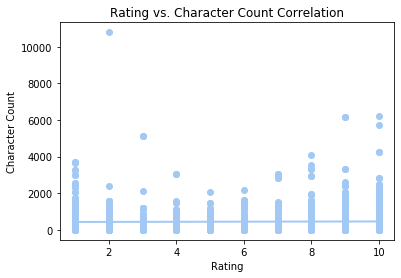

Correlation coefficient (r): 0.0211


In [579]:
# correlation of rating and character count
ratings = data.rating.values
character_counts = data.character_count.values

# calculate regression line and correlation coefficient
slope, intercept, r, p, stderr = stats.linregress(ratings, character_counts)

# plot regression line
plt.scatter(ratings, character_counts)
plt.plot(ratings, intercept + slope * ratings)
plt.xlabel('Rating')
plt.ylabel('Character Count')
plt.title('Rating vs. Character Count Correlation')
plt.show()

# print r
print('Correlation coefficient (r):', round(r,4))

## Rating by Drug Name

In [212]:
# only include drugs that have at least 50 reviews
drug_names = data.drugName.unique()
drug_counts = np.array([(i, data.drugName[data.drugName == i].count()) for i in drug_names])
drug_names_50 = [i[0] for i in drug_counts if i[1] >= '50']

### T-Test

In [580]:
# set alpha for t-test
alpha = 0.05

# define function for t-test
def ttest(data, column, value):
    ''' Run t-test and return p-value.'''
    has = data[data[column] == value].rating
    has_not = data[data[column] != value].rating
    t, p = stats.ttest_ind(has, has_not)
    return p

In [581]:
# perform t-test on ratings with and without each drug
pvalue_drugs = [(i, ttest(data, 'drugName', i)) for i in drug_names_50]

# return drugs with p-values below alpha and their p-values as an array
sig_drugs = [(i[0], float(i[1])) for i in pvalue_drugs if float(i[1]) < alpha]

# sort by p-value
sig_drugs.sort(key=lambda x:x[1])

In [609]:
# display 10 drugs with lowest p-values
top_sig_drugs = pd.DataFrame(sig_drugs[:10], columns=['drug_name', 'p_value'], index=range(1,11))
display('10 drugs with lowest p-value:', top_sig_drugs)

'10 drugs with lowest p-value:'

,drug_name,p_value
1,Medroxyprogesterone,4.633446e-104
2,Depo-Provera,1.331054e-103
3,Tioconazole,1.949702e-93
4,Varenicline,1.380933e-56
5,Alprazolam,8.222851e-56
6,Chantix,6.307876e-48
7,Nitrofurantoin,2.495301e-46
8,Clonazepam,7.634204e-45
9,Plan B,1.970601e-36
10,Blisovi 24 Fe,4.091911e-29


### Differences in Average Ratings

In [612]:
def diff_avg(data, column, value):
    """Return difference of mean ratings with and without each drug."""
    has = np.mean(data[data[column] == value].rating)
    has_not = np.mean(data[data[column] != value].rating)
    diff = has - has_not
    return diff

In [622]:
# make a list of sig_drugs
sig_drugs_list = [i[0] for i in sig_drugs]

# avgerage difference of mean rating for each drug
diff_avg_drugs = [(i, diff_avg(data, 'drugName', i)) for i in sig_drugs_list]

# sort by average difference
diff_avg_drugs.sort(key=lambda x:x[1])

In [659]:
# display 10 drugs with largest average increase
top_diff_avg_drugs = pd.DataFrame(diff_avg_drugs, columns=['drug_name', 'diff_avg'])
top_diff_avg_drugs = top_diff_avg_drugs.sort_values('diff_avg', ascending=False)[:10]
display('10 drugs with largest increase in mean ratings:', top_diff_avg_drugs)

'10 drugs with largest increase in mean ratings:'

,drug_name,diff_avg
232,Privine,3.004583
231,Zinc oxide,3.004564
230,Astelin,3.004564
229,Acetaminophen / pseudoephedrine,3.004545
228,Chlorpheniramine / phenylephrine,3.004526
227,Biafine,2.861682
226,Niravam,2.861682
225,Avonex Pen,2.837854
224,Belladonna / opium,2.837854
223,Primatene Mist,2.837854


In [660]:
# display 10 drugs with largest average decrease
bottom_diff_avg_drugs = pd.DataFrame(diff_avg_drugs, columns=['drug_name', 'diff_avg'])
bottom_diff_avg_drugs = bottom_diff_avg_drugs.sort_values('diff_avg', ascending=True)[:10]
display('10 drugs with largest increase in mean ratings:', bottom_diff_avg_drugs)

'10 drugs with largest increase in mean ratings:'

,drug_name,diff_avg
0,Systane,-4.870829
1,Succinylcholine,-4.620816
2,Trimethoprim,-4.245798
3,Chloraseptic Sore Throat Spray,-3.995760
4,Monistat 7,-3.964860
5,Blisovi 24 Fe,-3.885382
6,Rhofade,-3.773575
7,"Influenza virus vaccine, live, trivalent",-3.662458
8,Delsym,-3.509837
9,Estradiol Patch,-3.440223


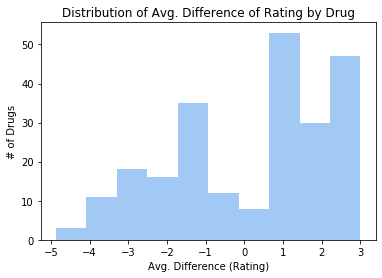

In [635]:
# plot distribution of average difference
diff_avgs = [i[1] for i in diff_avg_drugs]

plt.hist(diff_avgs, bins=10)
plt.xlabel('Avg. Difference (Rating)')
plt.ylabel('# of Drugs')
plt.title('Distribution of Avg. Difference of Rating by Drug')
plt.show()

## Rating by Condition

In [638]:
# only include conditions that have at least 50 reviews
condition_names = data.condition.unique()
condition_counts = np.array([(i, data.condition[data.condition == i].count()) for i in condition_names])
condition_names_50 = [i[0] for i in condition_counts if i[1] >= '50']

### T-Test

In [639]:
# set alpha for t-test
alpha = 0.05

In [640]:
# perform t-test on ratings with and without each drug
pvalue_conditions = [(i, ttest(data, 'condition', i)) for i in condition_names_50]

# only include drugs with p-values below alpha
sig_conditions = [(i[0], i[1]) for i in pvalue_conditions if float(i[1]) < alpha]

# sort
sig_conditions.sort(key=lambda x: x[1])

In [665]:
# display 10 conditions with lowest p-values
top_sig_conditions = pd.DataFrame(sig_conditions[:10], columns=['condition', 'p_value'], index=range(1,11))
display('10 conditions with lowest p-value:', top_sig_conditions)

'10 conditions with lowest p-value:'

,condition,p_value
1,Anxiety,3.263976e-62
2,Pain,1.438321e-54
3,Hyperhidrosis,6.641318e-54
4,HIV Infection,2.666925e-33
5,Hepatitis C,1.158493e-28
6,Sinusitis,8.789012e-25
7,Bacterial Infection,1.514498e-22
8,High Cholesterol,1.241918e-21
9,Psoriasis,5.527998e-21
10,Overactive Bladde,2.259705e-19


### Average Difference

In [642]:
# make a list of sig_drugs
sig_conditions_list = [i[0] for i in sig_conditions]

# avgerage difference of mean rating for each drug
diff_avg_conditions = [(i, diff_avg(data, 'condition', i)) for i in sig_conditions_list]

# sort by average difference
diff_avg_conditions.sort(key=lambda x:x[1])

In [661]:
# display 10 conditions with largest average increase
top_diff_avg_conditions = pd.DataFrame(diff_avg_conditions, columns=['condition', 'diff_avg'])
top_diff_avg_conditions = top_diff_avg_conditions.sort_values('diff_avg', ascending=False)[:10]
display('10 conditions with largest increase in mean ratings:', top_diff_avg_conditions)

'10 conditions with largest increase in mean ratings:'

,condition,diff_avg
74,Costochondritis,3.004583
73,Menopausal Disorders,3.004583
72,B12 Nutritional Deficiency,3.004564
71,von Willebrand's Disease,3.004545
70,Gingivitis,3.004526
69,NSAID-Induced Gastric Ulce,2.861682
68,Dumping Syndrome,2.837854
65,Biliary Cirrhosis,2.671181
64,Mucositis,2.671181
67,"Herpes Simplex, Mucocutaneous/Immunocompromise...",2.671181


In [663]:
# display 10 conditions with largest average decrease
bottom_diff_avg_conditions = pd.DataFrame(diff_avg_conditions, columns=['condition', 'diff_avg'])
bottom_diff_avg_conditions = bottom_diff_avg_conditions.sort_values('diff_avg', ascending=True)[:10]
display('10 conditions with largest increase in mean ratings:', bottom_diff_avg_conditions)

'10 conditions with largest increase in mean ratings:'

,condition,diff_avg
0,Bronchospasm Prophylaxis,-3.245748
1,Sore Throat,-3.106871
2,"Herpes Zoster, Prophylaxis",-2.995698
3,Macular Edema,-2.852853
4,Pancreatic Exocrine Dysfunction,-2.495710
5,"Deep Vein Thrombosis, Recurrent Event",-2.440167
6,Prostatitis,-2.436529
8,Pelvic Inflammatory Disease,-2.217933
7,Body Dysmorphic Disorde,-2.217933
9,Keratoconjunctivitis Sicca,-1.570189


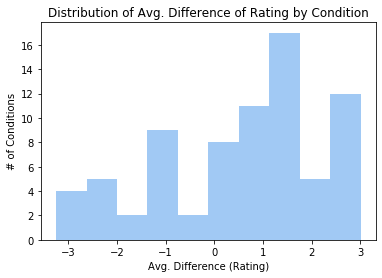

In [647]:
# plot distribution of average difference
diff_avgs = [i[1] for i in diff_avg_conditions]

plt.hist(diff_avgs, bins=10)
plt.xlabel('Avg. Difference (Rating)')
plt.ylabel('# of Conditions')
plt.title('Distribution of Avg. Difference of Rating by Condition')
plt.show()

## Rating by Word

In [44]:
# create array of terms
terms = term_matrix.columns

### T-test

In [46]:
# set alpha
alpha = 0.05

# define function for t-test
def ttest_term(data, term):
    ''' Run t-test on ratings with and without each term and return p-value.'''
    has = data[data[term] > 0].rating
    has_not = data[data[term] == 0].rating
    t, p = stats.ttest_ind(has, has_not)
    return p

In [490]:
# perform t-test on ratings with and without each term
pvalue_terms = [(i, ttest_term(term_matrix, i)) for i in terms]

# only include drugs with p-values below alpha
sig_terms = [(i[0], i[1]) for i in pvalue_terms if float(i[1]) < alpha]

# sort
sig_terms.sort(key=lambda x: x[1])

In [666]:
# display 10 words with lowest p-values
top_sig_terms = pd.DataFrame(sig_terms[:10], columns=['word', 'p_value'], index=range(1,11))
display('10 words with lowest p-value:', top_sig_terms)

'10 words with lowest p-value:'

,word,p_value
1,moist,0.000164
2,reported,0.000670
3,kept,0.000908
4,bloat,0.000996
5,agoraphobia,0.001343
6,stopped,0.001473
7,loopy,0.001696
8,restarted,0.001756
9,alarming,0.001783
10,levoxyl,0.001906


### Average Difference

In [537]:
def diff_avg_word(data, word):
    """Return difference of mean ratings with and without each word."""
    has = np.mean(data[data[word] != 0].rating)
    has_not = np.mean(data[data[word] == 0].rating)
    diff = has - has_not
    return diff

In [574]:
# extract terms from sig_terms
sig_term = [i[0] for i in sig_terms]

# avgerage difference of mean rating for each term
diff_avg_term = [(i, diff_avg_word(term_matrix, i)) for i in sig_term]

# sort by average difference
diff_avg_term.sort(key=lambda x:x[1])

In [667]:
# display 10 words with largest average increase
top_diff_avg_terms = pd.DataFrame(diff_avg_term, columns=['word', 'diff_avg'])
top_diff_avg_terms = top_diff_avg_terms.sort_values('diff_avg', ascending=False)[:10]
display('10 words with largest increase in mean ratings:', top_diff_avg_terms)

'10 words with largest increase in mean ratings:'

,word,diff_avg
341,radio,1.763794
340,coworker,1.534592
339,levoxyl,1.409158
338,aspergers,1.399081
337,laminectomy,1.387501
336,loaded,1.371777
335,managable,1.368772
334,epileptic,1.366272
333,simplest,1.360792
332,natazia,1.332585


In [669]:
# display 10 words with largest average decrease
bottom_diff_avg_terms = pd.DataFrame(diff_avg_term, columns=['word', 'diff_avg'])
bottom_diff_avg_terms = bottom_diff_avg_terms.sort_values('diff_avg', ascending=True)[:10]
display('10 words with largest decrease in mean ratings:', bottom_diff_avg_terms)

'10 words with largest decrease in mean ratings:'

,word,diff_avg
0,moist,-2.147107
1,consists,-1.495447
2,separation,-1.481187
3,tumour,-1.432935
4,wire,-1.432935
5,meanwhile,-1.427359
6,prednisolone,-1.401679
7,manufactured,-1.395454
8,fasciitis,-1.389374
9,compressed,-1.337571


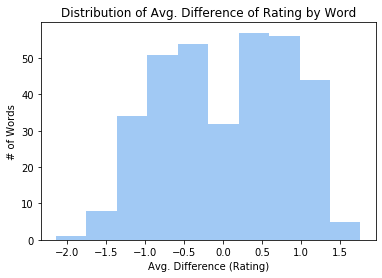

In [671]:
# plot distribution of average difference
diff_avgs = [i[1] for i in diff_avg_term]

plt.hist(diff_avgs, bins=10)
plt.xlabel('Avg. Difference (Rating)')
plt.ylabel('# of Words')
plt.title('Distribution of Avg. Difference of Rating by Word')
plt.show()